In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import numpy as np

def get_stock_data(symbol,duration):
    def mkdays(val):
        return val.days
    def mkdaystr(val):
        return val.strftime('%Y.%m.%d')
    df = yf.Ticker(symbol).history(duration)
    df['Company'] = symbol
    df['Date'] = df.index
    df.reset_index(drop=True, inplace=True)
    vals = df.Date - df.Date[0] 
    df['Days'] = list( map( mkdays, vals ) )
    df['Daystring'] = list( map( mkdaystr, df.Date ) )
    # df = df[['Date','Company','Close','Volume']]
    return df

def thinticks(df, showeach):
    val = df.Days
    lab = df.Date
    vals = []
    labs = []
    k = 0
    while k < len(val):
        vals.append( val[k] )
        labs.append( lab[k].strftime('%Y.%m.%d') )
        k = k + showeach
    return vals, labs
    
def standard_plot(df, showeach, title_string, window):
    def findwindowave(values, window):
        mx = len(values)
        windowave = []
        for k in range(0,mx):
            left = right = k
            if k > window:
                left = k - window
            if (k+window) < mx:
                right = k + window
            windowave.append( np.average( values[left:right] ) )
        return windowave
    
    plt.figure(figsize=(9,3))
        
    x, y = df.Days, df.Close
    plt.scatter(x, y,  s=1, c='black')
    plt.scatter(x, findwindowave(y, window),  s=10, c='black')
    #plt.scatter(x, df.Low,  s=1, c='blue')
    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs, rotation=90)
    plt.ylabel('Close $')
    plt.xlabel('Date')
    plt.title(title_string)
    
    plt.show()
    
def findwindowave(values, window):
    mx = len(values)
    windowave = []
    for k in range(0,mx):
        left = right = k
        if k > window:
            left = k - window
        if (k+window) < mx:
            right = k + window
        windowave.append( np.average( values[left:right] ) )
    return windowave


# This creates a plot with two axis.  One in $ and the second as Fraction relative
# to the observed minimum.  
def doubleplot(df, showeach, title_string, window):
    x = df.Days
    y = df.Close
    yavg = findwindowave(y, window)
    mn = min( list(df.Close) )
    ynorm = df.Close / mn
    ynormf = findwindowave(ynorm, window)
    
    
    fig, ax1 = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Share Price [$]', color='black')
    ax1.plot(x, y, linestyle='None', marker='.', color='blue', markersize=5)
    ax1.plot(x, yavg, linestyle='None', marker='.', color='green', markersize=10)
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    # this is an invisible series intentionally right now.  
    # the 'Fraction' axis is slightly offset from the $ axis.  
    # This will be fixed but currently the Fraction axis serves to show 
    # the percentage gain/losses compared to the minima seen on the current time 
    # window

    ax2.set_ylabel('Fraction', color='black')  # we already handled the x-label with ax1
    ax2.plot(x, ynormf, linestyle='None', marker='.', color='black', markersize=0)
    ax2.tick_params(axis='y', labelcolor='black')
    
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs)
    matplotlib.pyplot.sca(ax1)
    plt.xticks(rotation=90)
    plt.title(title_string)

    plt.show()
    standard_plot(df, showeach, title_string, window)


# This creates a plot with two axis.  One is value invested
def doubleplot_(df, showeach, title_string, window):
    x = df.Days
    
    fig, ax1 = plt.subplots()
    fig.set_figheight(3)
    fig.set_figwidth(9)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value Owned[$]', color='black')
    ax1.plot(x, df.value, linestyle='None', marker='.', color='blue', markersize=5)
    ax1.plot(x, df.spent, linestyle='None', marker='.', color='green', markersize=10)
    
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped

    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs)
    matplotlib.pyplot.sca(ax1)
    plt.xticks(rotation=90)
    plt.title(title_string)

    plt.show()
    standard_plot(df, showeach, '', window)

    
def create_invested(invested,df):
    df.loc[( (df.Daystring>=invested[0]) ),'shares'] = \
        df.loc[( (df.Daystring>=invested[0]) ),'shares'] + invested[2]
    df.loc[( (df.Daystring>=invested[0]) ),'spent'] = \
        df.loc[( (df.Daystring>=invested[0]) ),'spent'] + invested[1]    
    return df

def add_instestments(df,investments,symbol):
    df['shares'] = 0.00 
    df['spent'] = 0.00 
    df['gain'] = 0.00 
    for invest in investments[symbol]:
        df = create_invested(invest,df)
        df['value'] = df['Close'] * df['shares']
        df.loc[( (df['shares']>0.00) ),'gain'] = \
           df.loc[( (df['shares']>0.00) ),'value']/df.loc[( (df['shares']>0.00) ),'spent']
    return df   


def portfolio_value(investments, symbol):
    invested = investments[symbol]
    df = yf.Ticker(symbol).history('1d')
    shares = 0
    outlay = 0
    close = 0
    for investment in invested:
        shares = shares + investment[2]
        outlay = outlay + investment[1]
    if np.isnan(df.Close[0]):
        value = 0
        price = 0
        close = 0
        message = 'No close value found for {0}'.format(symbol)
        print(message)
        message = 'raw data was:'
        print(message)
        print(df.head(1))
    else:
        close = df.Close[0]
        value = shares * close
        price = df.Close[0]
    result = {'symbol':symbol,'price':price,'shares': \
              shares,'value': value,'outlay': outlay, 'close':close, 'ratio':(value/outlay)}
    return result

In [2]:
showeach = 5
duration = '120d'
window = 3

In [3]:
investments = {
    'OKTA':[('2020.05.20',250,1.33192)],
    'ADBE':[
           ('2020.06.05',250,0.6363), 
           ('2020.06.22',80,0.18239)
           ],
    'AMZN':[
           ('2020.05.06',250,0.10632),
           ('2020.04.06',250,0.12515),
           ('2020.04.26',500,0.21043),
           ('2020.04.02',500,0.26057),
           ('2020.03.10',250,0.1373),
           ('2020.05.27',500,0.20823),
           ('2020.06.18',500,0.18839)
           ],
    'APPN':[('2020.02.22',300,6.413)],
    'WORK':[
            ('2020.02.22',300,10.74499),
            ('2020.03.10',500,21.16851)
           ],
    'ALB':[
           ('2020.02.22',300,3.34785),
           ('2020.03.02',250,2.9656),
           ('2020.03.10',500,7.1353),
           ('2020.04.40',250,4.39136)
          ],
    'ESTC':[('2020.04.21',250,4.26913)],
    'RDFN':[
            ('2020.03.05',600,20.82611),
            ('2020.03.10',250,11.51013)
           ],
    'GOOGL':[('2020.02.28',500,0.36067)],
    'SQM':[
           ('2020.03.03',500,17.08818),
           ('2020.03.11',500,20.88555)
          ],
    'LTHM':[('2020.03.11',100,16.33987)],
    'TSLA':[
            ('2020.03.06',500,0.71075),
            ('2020.03.11',500,0.78836),
            ('2020.03.18',250,0.6921)
           ],
    'T':[
        ('2020.07.07',200,6.596131), 
        ('2020.07.15',430,14.32856), 
        ('2020.07.17',430,14.21488),
        ('2020.07.22',300,9.94695),
        ('2020.07.29',100,3.38295),
        ('2020.08.05',2000,67.00168)
        
    ],
    'NHI':[('2020.08.05',2000,32.07699)],
    'MMM':[('2020.07.07',200,1.29183)],
    'TMUS':[('2020.07.07',100,0.94518),('2020.07.22',100,0.95302)],
    'LMND':[('2020.07.29',300,4.34468)]
}

dividends = {
    'SQM':[('2020.06.23',4.39), ('2020.06.02',6.61)],
    'ALB':[('2020.04.02',5.18),('2020.07.02',6.87)]
}

OKTA


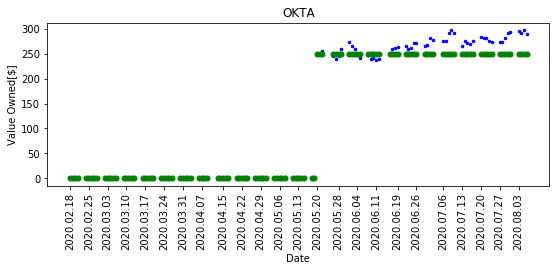

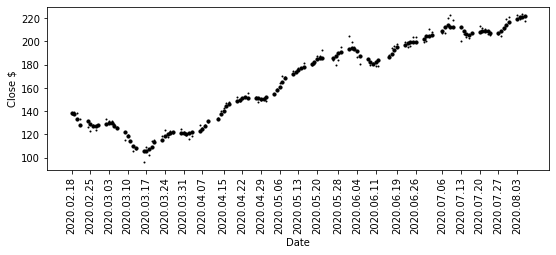

ADBE


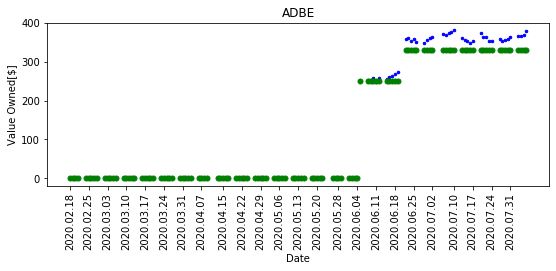

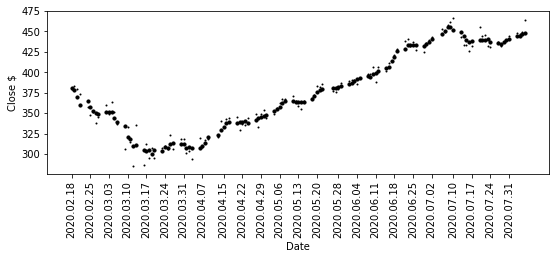

AMZN


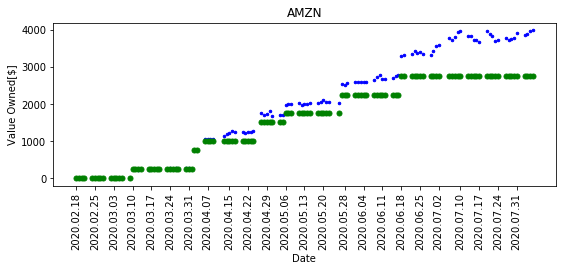

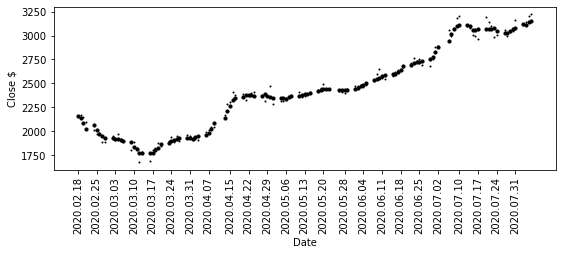

APPN


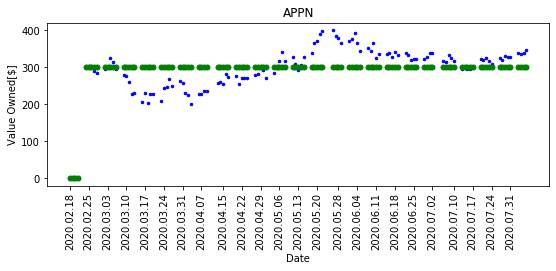

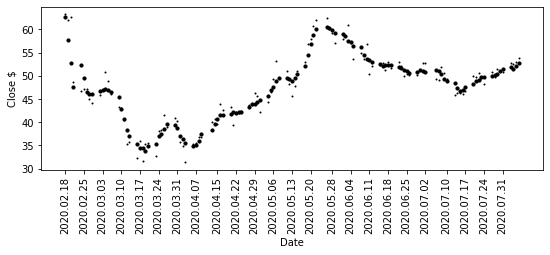

WORK


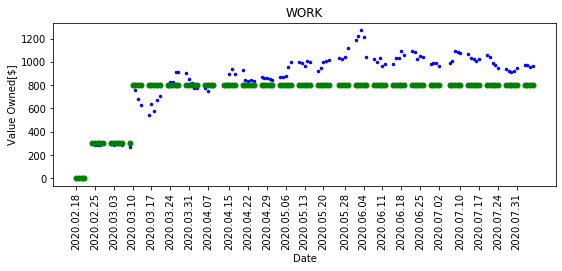

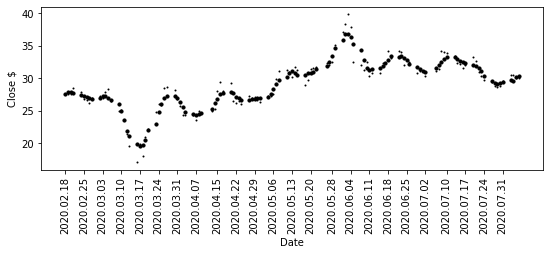

ALB


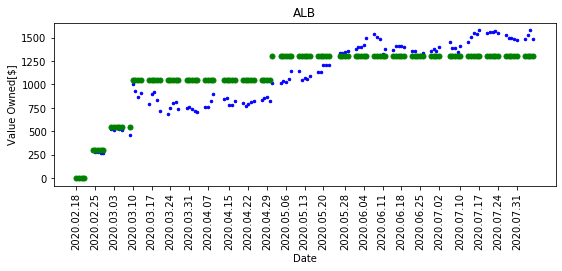

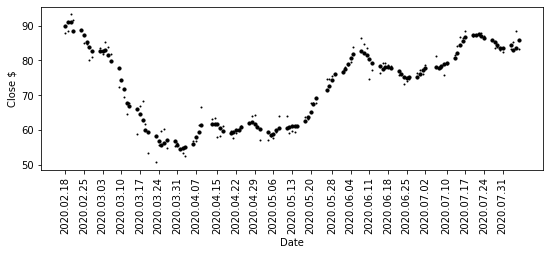

ESTC


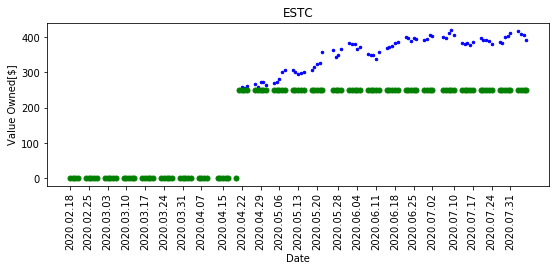

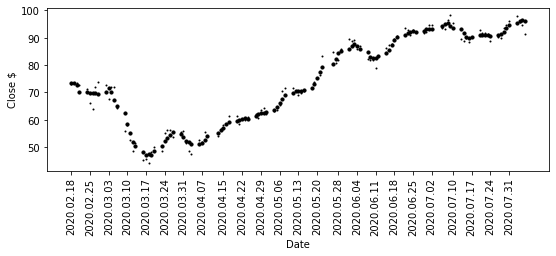

RDFN


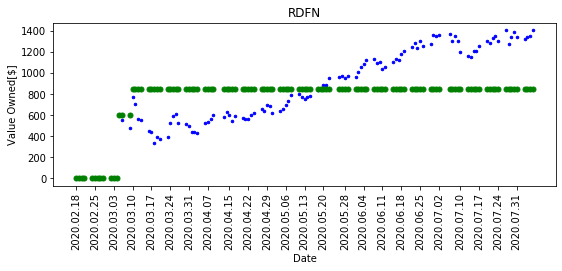

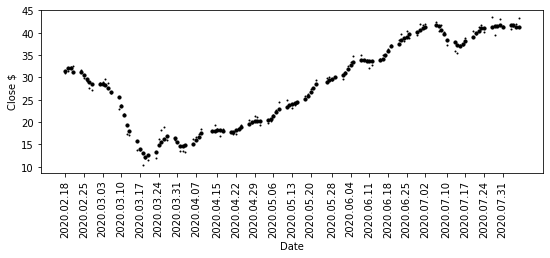

GOOGL


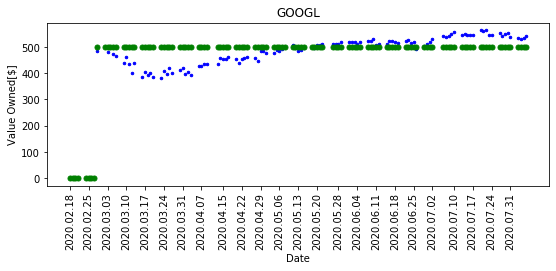

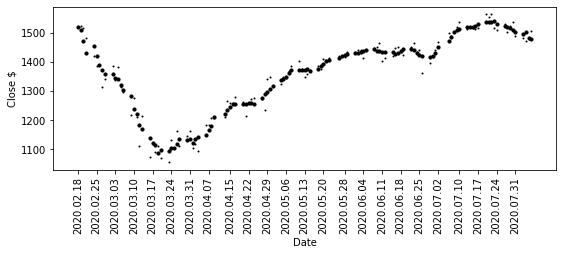

SQM


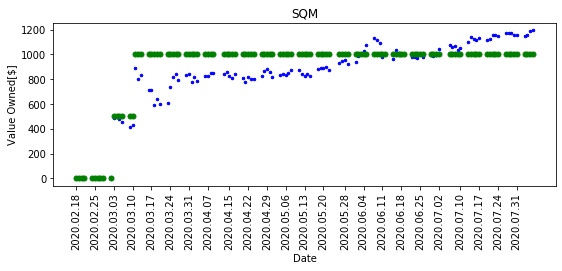

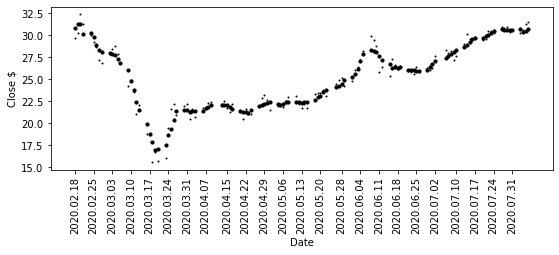

LTHM


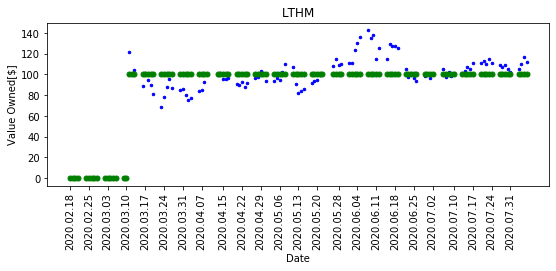

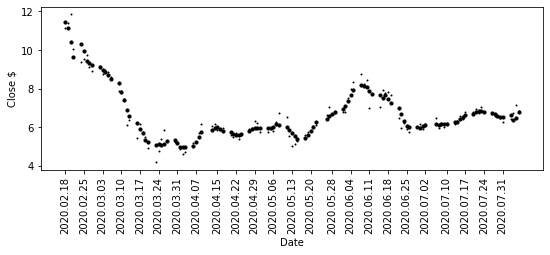

TSLA


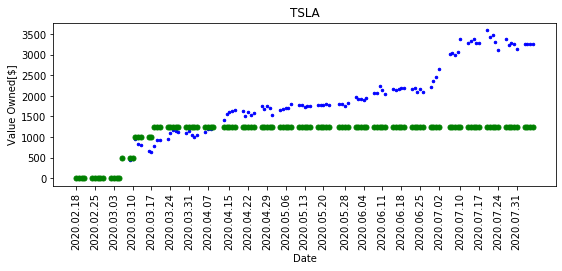

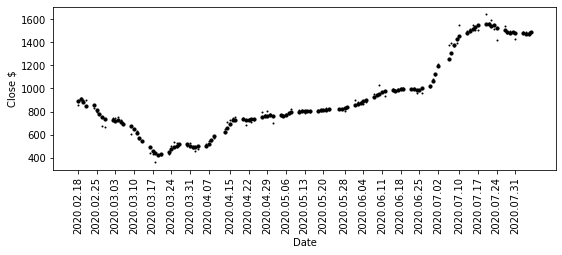

T


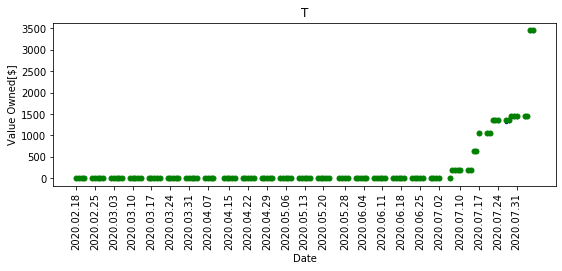

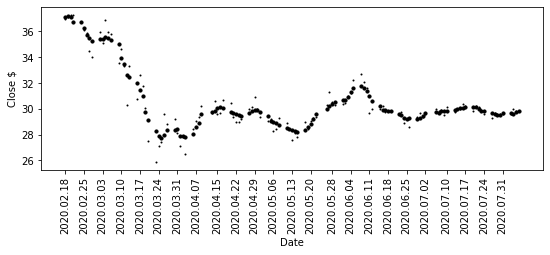

NHI


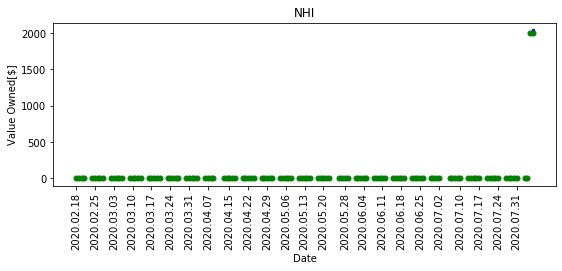

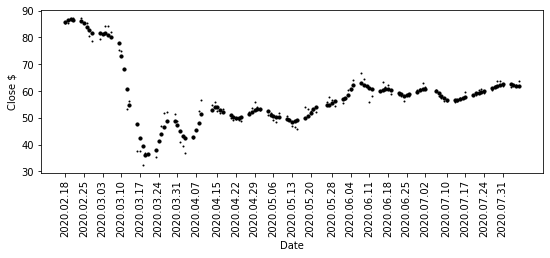

MMM


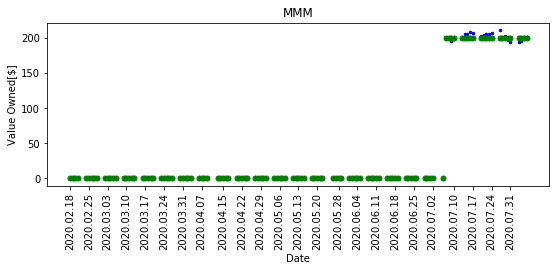

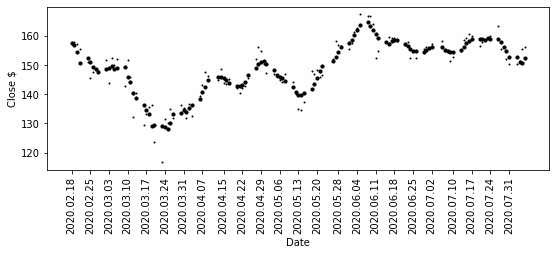

TMUS


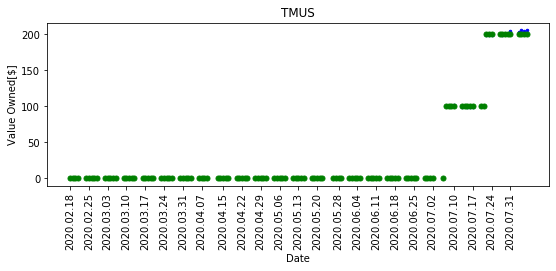

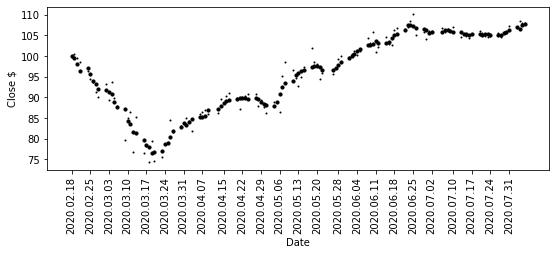

LMND


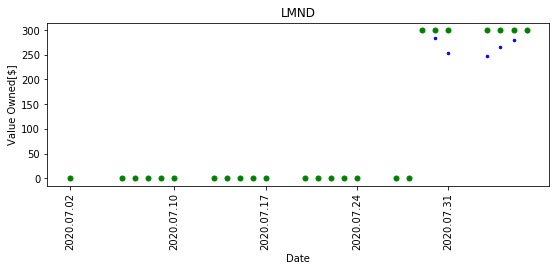

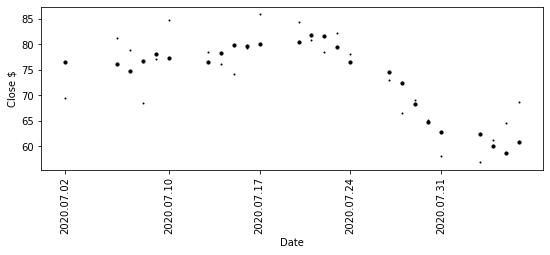

In [4]:
for symbol in investments.keys():
    print(symbol)
    df = get_stock_data(symbol,duration)
    df = add_instestments(df,investments,symbol)
    title_string = symbol
    #doubleplot(df, showeach, title_string, window)
    doubleplot_(df, showeach, title_string, window)

In [5]:
symbols = [
 'T',
 'OKTA',
 'AMZN',
 'APPN',
 'WORK',
 'ALB',
 'ADBE',
 'ESTC',
 'RDFN',
 'GOOGL',
 'SQM',
 'LTHM',
 'TSLA',
 'TMUS',
 'MMM',
 'LMND',
 'NHI'
]
total = list( map(portfolio_value, [investments]*len(symbols), symbols) )

In [6]:
outlay = value = 0
labels = []
val_ = []
inv_ = []
per_ = []
gain_ = []
shares = []
close = []
for tik in total:
    outlay = tik['outlay']+ outlay
    value = tik['value']+value
    labels.append(tik['symbol'])
    val_.append(tik['value'])
    inv_.append(tik['outlay'])
    gain_.append(tik['ratio'])
    shares.append(tik['shares'])
    close.append(tik['close'])

# print((outlay,value,value/outlay))
import pandas as pd

df = pd.DataFrame.from_dict({'symbol':labels,
                             'close':close,
                            'invested':inv_,
                            'value':val_,
                             'gain':gain_,
                             'shares':shares
                            }).sort_values(by=['gain'])

df['percentage_invested'] = df.invested/sum(df.invested)
df['percentage_value'] = df.value/sum(df.value)
df['cp'] = df['invested']/df['shares']

fields = ['symbol','gain','invested','value','shares','close','cp','percentage_value','percentage_invested']
df[fields].head(20)

,symbol,gain,invested,value,shares,close,cp,percentage_value,percentage_invested
15,LMND,0.994932,300,298.479516,4.344680,68.70,69.049965,0.014522,0.018939
0,T,0.995855,3460,3445.659146,115.471151,29.84,29.964194,0.167642,0.218434
14,MMM,1.007627,200,201.525480,1.291830,156.00,154.819133,0.009805,0.012626
16,NHI,1.021652,2000,2043.304263,32.076990,63.70,62.349990,0.099413,0.126263
13,TMUS,1.025977,200,205.195420,1.898200,108.10,105.362975,0.009983,0.012626
9,GOOGL,1.085581,500,542.790317,0.360670,1504.95,1386.308814,0.026408,0.031566
11,LTHM,1.120915,100,112.091508,16.339870,6.86,6.120000,0.005454,0.006313
5,ALB,1.143688,1300,1486.794767,17.840110,83.34,72.869506,0.072337,0.082071
6,ADBE,1.151401,330,379.962216,0.818690,464.11,403.082974,0.018486,0.020833
3,APPN,1.152202,300,345.660700,6.413000,53.90,46.779978,0.016818,0.018939


In [7]:
i = sum(df.invested)
v = sum(df.value)
g = v/i
print((i,int(v),int(g*100)))

(15840, 20553, 129)


In [8]:
def mklab(s1,s2,s3,s4):
    return '{0}\ninvested:{1}\nvalue:{2}\ngain:{3:6.4f}'.format(s1,s2,int(s3),s4)

In [9]:
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain) )

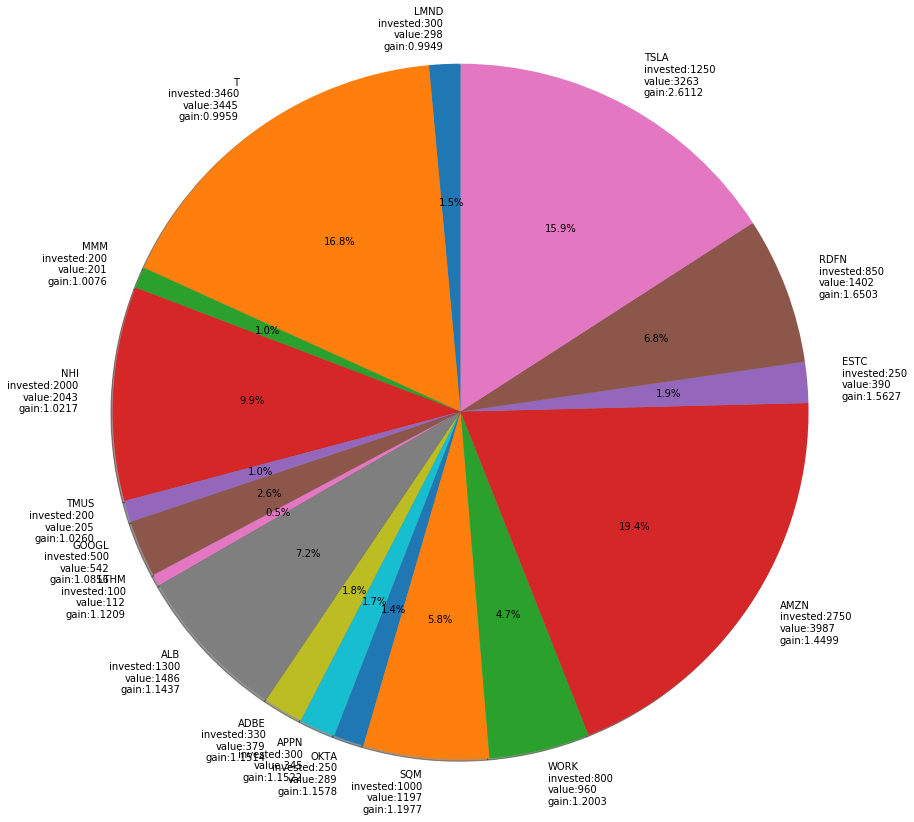

In [10]:
fig1, ax1 = plt.subplots()
ax1.pie(df.value, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(df.invested, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(df.gain, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
showeach = 1
duration = '28d'
window = 1

symbol = 'LMND'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)



In [ ]:
showeach = 7
duration = '112d'
window = 7



In [ ]:
symbol = 'ADBE'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)




In [ ]:
# ATT 0.52 dividend per share.  $30 on Jun-5.
symbol = 'T'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# T Mobile
symbol = 'TMUS'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3M - aristocrat
symbol = 'MMM'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'FSLY'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'CRWD'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Costco and Kroger
symbol = 'COST'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'KR'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'WMT'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'MELI'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'SQ'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Dominiion energy
symbol = 'D'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Education online
symbol = 'TWOU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'CHGG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'BEDU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Zillow 
symbol = 'ZG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# Redfin 
symbol = 'RDFN'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'ROKU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# 3D printer.  Proto Labs
symbol = 'PRLB'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3D printer.  Strata Sys.  
symbol = 'SSYS'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3D printer.  3D Systems
symbol = 'DDD'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Fuel cell.  
symbol = 'PLUG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# Fuel cell.  Vancouver
symbol = 'BLDP'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'T'
duration = '120d'
df = get_stock_data(symbol,duration)

In [ ]:
df.head(120)